In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
from transformers import AutoTokenizer
import re

In [2]:
torch.manual_seed(3407)

In [3]:
df=pd.read_csv('/kaggle/input/peptide/data.csv')

In [4]:
df.shape

(134281, 4)

In [5]:
df['mhc'].value_counts()

mhc
QEFFIASGAAVDAIMWLFLECYDLQRATYHVGFT    10412
QEFFIASGAAVDAIMWGYFELYVIDRQTVHVGFT     6325
QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT     6317
QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT     6045
QEFFIASGAAVDAIMESSYDYFDLQKRNYHVVFT     5352
                                      ...  
QEFFIASGAAVDAIMESGFDYYDFDRLTYHVVFT        3
QEFFIASGAAVDAIMQDYFHGYDFDRATYHVGFT        2
QEFFIASGAAVDAIMEVHFDYYSLQRETYHVVFT        2
QEFFIASGAAVDAIMESSFEYYDLQRATYHVGFT        1
QEFFIASGAAVDAIMWPRFDHFDIQAATYHVVFT        1
Name: count, Length: 75, dtype: int64

In [6]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [8]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [9]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [10]:
vocab_size = len(tokenizer.get_vocab())
print(vocab_size)

33


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)


In [13]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [14]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [15]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [16]:
y = scores

In [17]:
X = torch.stack((pep_input_ids,mhc_input_ids,pep_attention_mask,mhc_attention_mask),dim=1)
y = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [20]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1],X_val[:,2],X_val[:,3], y_val)
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3],y_test)

In [21]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=39):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.clamp(
            torch.arange(0, model_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / model_dim),
            min=-10, max=10
        ))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, model_dim, num_heads, num_layers, max_len=39, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim, max_len)
        self.norm = nn.LayerNorm(model_dim)  # LayerNorm
        self.encoder_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
    
    def forward(self, x, padding_mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.norm(x)
        return self.encoder_layers(x, src_key_padding_mask=padding_mask)

class CrossAttentionLayer(nn.Module):
    def __init__(self, model_dim, num_heads, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.cross_attention = nn.MultiheadAttention(model_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, pep_refined, mhc_refined):
        attn_output, _ = self.cross_attention(mhc_refined, pep_refined, pep_refined)
        attn_output = self.norm(mhc_refined + self.dropout(attn_output))
        return attn_output

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, model_dim, num_heads, num_layers, dropout=0.1, max_len=39):
        super(TransformerModel, self).__init__()
        self.encoder_pep = TransformerEncoder(vocab_size, model_dim, num_heads, num_layers, max_len, dropout)
        self.encoder_mhc = TransformerEncoder(vocab_size, model_dim, num_heads, num_layers, max_len, dropout)
        self.cross_attention = CrossAttentionLayer(model_dim, num_heads, dropout) 
        self.norm_fc1 = nn.LayerNorm(model_dim)
        self.norm_fc2 = nn.LayerNorm(512)
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, pep_input, mhc_input, pep_mask, mhc_mask):
        pep_padding_mask = ~(pep_mask.bool())
        mhc_padding_mask = ~(mhc_mask.bool())
        pep_refined = self.encoder_pep(pep_input, padding_mask=pep_padding_mask)
        mhc_refined = self.encoder_mhc(mhc_input, padding_mask=mhc_padding_mask)
        cross_output = self.cross_attention(pep_refined, mhc_refined)
        x = cross_output.mean(dim=1)
        x = self.norm_fc1(x)
        x = F.gelu(self.fc1(x))
        x = self.norm_fc2(x)
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
!pip install optuna

In [29]:
import optuna
from optuna.trial import TrialState
import torch
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
def objective(trial):
    model_dim = trial.suggest_categorical("model_dim",[64,128,256,512])
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    num_layers = trial.suggest_categorical("num_layers", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    lr = trial.suggest_categorical("learning_rate", [1e-4, 1e-3])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-2, 1e-3, 1e-4, 1e-5])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    model = TransformerModel(
        model_dim=model_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout=dropout,
        vocab_size=vocab_size
    ).to(device)

    criterion = nn.HuberLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(5):
        model.train()
        train_loss = 0
        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
            pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                pep_ids.to(device), mhc_ids.to(device),
                pep_mask.to(device), mhc_mask.to(device),
                scores.to(device)
            )

            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids, pep_mask, mhc_mask)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        total_val_preds = []
        total_val_labels = []
        with torch.no_grad():
            for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
                pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                    pep_ids.to(device), mhc_ids.to(device),
                    pep_mask.to(device), mhc_mask.to(device),
                    scores.to(device)
                )

                outputs = model(pep_ids, mhc_ids, pep_mask, mhc_mask)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(outputs.cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)

        total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
        total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
        val_r2 = r2_score(total_val_labels, total_val_preds)
        val_mse = mean_squared_error(total_val_labels, total_val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(total_val_labels, total_val_preds)

        print(f"Trial Results: Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}, Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial

print(f"  Val Loss: {trial.value:.4f}")
print(f"  Hyperparameters: {trial.params}")

best_hyperparams = trial.params


[I 2025-02-28 07:54:40,849] A new study created in memory with name: no-name-dfedc4c9-a444-4cc3-9f1b-62e8c4536df8


Trial Results: Val Loss: 0.0276, Val R^2: 0.1956, Val MSE: 0.0552, Val RMSE: 0.2349, Val MAE: 0.1956
Trial Results: Val Loss: 0.0228, Val R^2: 0.3345, Val MSE: 0.0456, Val RMSE: 0.2136, Val MAE: 0.1753
Trial Results: Val Loss: 0.0211, Val R^2: 0.3857, Val MSE: 0.0421, Val RMSE: 0.2052, Val MAE: 0.1656
Trial Results: Val Loss: 0.0207, Val R^2: 0.3959, Val MSE: 0.0414, Val RMSE: 0.2035, Val MAE: 0.1654


[I 2025-02-28 07:59:05,761] Trial 0 finished with value: 0.020804169831708783 and parameters: {'model_dim': 128, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'batch_size': 256}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0208, Val R^2: 0.3932, Val MSE: 0.0416, Val RMSE: 0.2040, Val MAE: 0.1653
Trial Results: Val Loss: 0.0343, Val R^2: -0.0002, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2190
Trial Results: Val Loss: 0.0344, Val R^2: -0.0032, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2190
Trial Results: Val Loss: 0.0343, Val R^2: -0.0013, Val MSE: 0.0687, Val RMSE: 0.2620, Val MAE: 0.2195
Trial Results: Val Loss: 0.0344, Val R^2: -0.0025, Val MSE: 0.0688, Val RMSE: 0.2622, Val MAE: 0.2198


[I 2025-02-28 08:12:04,955] Trial 1 finished with value: 0.0347106532814602 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 256}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0347, Val R^2: -0.0123, Val MSE: 0.0694, Val RMSE: 0.2635, Val MAE: 0.2212
Trial Results: Val Loss: 0.0244, Val R^2: 0.2898, Val MSE: 0.0487, Val RMSE: 0.2207, Val MAE: 0.1823
Trial Results: Val Loss: 0.0232, Val R^2: 0.3233, Val MSE: 0.0464, Val RMSE: 0.2154, Val MAE: 0.1764
Trial Results: Val Loss: 0.0216, Val R^2: 0.3702, Val MSE: 0.0432, Val RMSE: 0.2078, Val MAE: 0.1681
Trial Results: Val Loss: 0.0214, Val R^2: 0.3764, Val MSE: 0.0428, Val RMSE: 0.2068, Val MAE: 0.1674


[I 2025-02-28 08:16:34,175] Trial 2 finished with value: 0.020919483609586245 and parameters: {'model_dim': 128, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'batch_size': 128}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0209, Val R^2: 0.3899, Val MSE: 0.0418, Val RMSE: 0.2045, Val MAE: 0.1637
Trial Results: Val Loss: 0.0250, Val R^2: 0.2709, Val MSE: 0.0500, Val RMSE: 0.2236, Val MAE: 0.1838
Trial Results: Val Loss: 0.0245, Val R^2: 0.2845, Val MSE: 0.0491, Val RMSE: 0.2215, Val MAE: 0.1815
Trial Results: Val Loss: 0.0237, Val R^2: 0.3085, Val MSE: 0.0474, Val RMSE: 0.2178, Val MAE: 0.1760
Trial Results: Val Loss: 0.0231, Val R^2: 0.3262, Val MSE: 0.0462, Val RMSE: 0.2150, Val MAE: 0.1742


[I 2025-02-28 08:19:58,773] Trial 3 finished with value: 0.022191945286024185 and parameters: {'model_dim': 64, 'num_heads': 8, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'batch_size': 128}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0222, Val R^2: 0.3528, Val MSE: 0.0444, Val RMSE: 0.2107, Val MAE: 0.1710
Trial Results: Val Loss: 0.0250, Val R^2: 0.2699, Val MSE: 0.0501, Val RMSE: 0.2238, Val MAE: 0.1832
Trial Results: Val Loss: 0.0231, Val R^2: 0.3250, Val MSE: 0.0463, Val RMSE: 0.2152, Val MAE: 0.1765
Trial Results: Val Loss: 0.0223, Val R^2: 0.3499, Val MSE: 0.0446, Val RMSE: 0.2111, Val MAE: 0.1724
Trial Results: Val Loss: 0.0228, Val R^2: 0.3339, Val MSE: 0.0457, Val RMSE: 0.2137, Val MAE: 0.1747


[I 2025-02-28 08:23:26,153] Trial 4 finished with value: 0.02263491719107454 and parameters: {'model_dim': 64, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 64}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0226, Val R^2: 0.3397, Val MSE: 0.0453, Val RMSE: 0.2128, Val MAE: 0.1729
Trial Results: Val Loss: 0.0343, Val R^2: 0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0343, Val R^2: 0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0306, Val R^2: 0.1086, Val MSE: 0.0611, Val RMSE: 0.2472, Val MAE: 0.2037
Trial Results: Val Loss: 0.0309, Val R^2: 0.0987, Val MSE: 0.0618, Val RMSE: 0.2486, Val MAE: 0.2050


[I 2025-02-28 08:27:01,811] Trial 5 finished with value: 0.032967402799321074 and parameters: {'model_dim': 128, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'batch_size': 256}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0330, Val R^2: 0.0385, Val MSE: 0.0659, Val RMSE: 0.2568, Val MAE: 0.2107
Trial Results: Val Loss: 0.0317, Val R^2: 0.0756, Val MSE: 0.0634, Val RMSE: 0.2518, Val MAE: 0.2074
Trial Results: Val Loss: 0.0341, Val R^2: 0.0046, Val MSE: 0.0683, Val RMSE: 0.2613, Val MAE: 0.2144
Trial Results: Val Loss: 0.0328, Val R^2: 0.0438, Val MSE: 0.0656, Val RMSE: 0.2561, Val MAE: 0.2118
Trial Results: Val Loss: 0.0305, Val R^2: 0.1104, Val MSE: 0.0610, Val RMSE: 0.2470, Val MAE: 0.2062


[I 2025-02-28 08:30:32,552] Trial 6 finished with value: 0.030610144944928055 and parameters: {'model_dim': 128, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 32}. Best is trial 0 with value: 0.020804169831708783.


Trial Results: Val Loss: 0.0306, Val R^2: 0.1073, Val MSE: 0.0612, Val RMSE: 0.2474, Val MAE: 0.2046
Trial Results: Val Loss: 0.0251, Val R^2: 0.2668, Val MSE: 0.0503, Val RMSE: 0.2242, Val MAE: 0.1841
Trial Results: Val Loss: 0.0221, Val R^2: 0.3562, Val MSE: 0.0442, Val RMSE: 0.2101, Val MAE: 0.1707
Trial Results: Val Loss: 0.0200, Val R^2: 0.4157, Val MSE: 0.0401, Val RMSE: 0.2002, Val MAE: 0.1616
Trial Results: Val Loss: 0.0187, Val R^2: 0.4543, Val MSE: 0.0374, Val RMSE: 0.1935, Val MAE: 0.1540


[I 2025-02-28 08:39:38,537] Trial 7 finished with value: 0.01781930033827112 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 256}. Best is trial 7 with value: 0.01781930033827112.


Trial Results: Val Loss: 0.0178, Val R^2: 0.4803, Val MSE: 0.0356, Val RMSE: 0.1888, Val MAE: 0.1496
Trial Results: Val Loss: 0.0355, Val R^2: -0.0343, Val MSE: 0.0709, Val RMSE: 0.2663, Val MAE: 0.2210
Trial Results: Val Loss: 0.0343, Val R^2: -0.0004, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2190
Trial Results: Val Loss: 0.0344, Val R^2: -0.0023, Val MSE: 0.0687, Val RMSE: 0.2622, Val MAE: 0.2197
Trial Results: Val Loss: 0.0344, Val R^2: -0.0025, Val MSE: 0.0688, Val RMSE: 0.2622, Val MAE: 0.2190


[I 2025-02-28 08:54:08,976] Trial 8 finished with value: 0.034302003152247164 and parameters: {'model_dim': 512, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 7 with value: 0.01781930033827112.


Trial Results: Val Loss: 0.0343, Val R^2: -0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0349, Val R^2: -0.0179, Val MSE: 0.0698, Val RMSE: 0.2642, Val MAE: 0.2198
Trial Results: Val Loss: 0.0343, Val R^2: 0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0284, Val R^2: 0.1703, Val MSE: 0.0569, Val RMSE: 0.2385, Val MAE: 0.1965
Trial Results: Val Loss: 0.0277, Val R^2: 0.1924, Val MSE: 0.0554, Val RMSE: 0.2353, Val MAE: 0.1922


[I 2025-02-28 08:57:35,305] Trial 9 finished with value: 0.028268055890553763 and parameters: {'model_dim': 128, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'batch_size': 128}. Best is trial 7 with value: 0.01781930033827112.


Trial Results: Val Loss: 0.0283, Val R^2: 0.1755, Val MSE: 0.0565, Val RMSE: 0.2378, Val MAE: 0.1976
Trial Results: Val Loss: 0.0218, Val R^2: 0.3640, Val MSE: 0.0436, Val RMSE: 0.2088, Val MAE: 0.1697
Trial Results: Val Loss: 0.0188, Val R^2: 0.4502, Val MSE: 0.0377, Val RMSE: 0.1942, Val MAE: 0.1547
Trial Results: Val Loss: 0.0183, Val R^2: 0.4653, Val MSE: 0.0367, Val RMSE: 0.1915, Val MAE: 0.1505
Trial Results: Val Loss: 0.0176, Val R^2: 0.4861, Val MSE: 0.0352, Val RMSE: 0.1877, Val MAE: 0.1465


[I 2025-02-28 09:02:09,638] Trial 10 finished with value: 0.01686131397617005 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 10 with value: 0.01686131397617005.


Trial Results: Val Loss: 0.0169, Val R^2: 0.5082, Val MSE: 0.0337, Val RMSE: 0.1837, Val MAE: 0.1445
Trial Results: Val Loss: 0.0229, Val R^2: 0.3321, Val MSE: 0.0458, Val RMSE: 0.2140, Val MAE: 0.1751
Trial Results: Val Loss: 0.0194, Val R^2: 0.4329, Val MSE: 0.0389, Val RMSE: 0.1972, Val MAE: 0.1577
Trial Results: Val Loss: 0.0199, Val R^2: 0.4197, Val MSE: 0.0398, Val RMSE: 0.1995, Val MAE: 0.1606
Trial Results: Val Loss: 0.0172, Val R^2: 0.4976, Val MSE: 0.0345, Val RMSE: 0.1856, Val MAE: 0.1461


[I 2025-02-28 09:06:44,551] Trial 11 finished with value: 0.01688583746519206 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 10 with value: 0.01686131397617005.


Trial Results: Val Loss: 0.0169, Val R^2: 0.5075, Val MSE: 0.0338, Val RMSE: 0.1838, Val MAE: 0.1439
Trial Results: Val Loss: 0.0217, Val R^2: 0.3678, Val MSE: 0.0434, Val RMSE: 0.2082, Val MAE: 0.1680
Trial Results: Val Loss: 0.0195, Val R^2: 0.4318, Val MSE: 0.0390, Val RMSE: 0.1974, Val MAE: 0.1575
Trial Results: Val Loss: 0.0183, Val R^2: 0.4660, Val MSE: 0.0366, Val RMSE: 0.1914, Val MAE: 0.1520
Trial Results: Val Loss: 0.0180, Val R^2: 0.4741, Val MSE: 0.0361, Val RMSE: 0.1899, Val MAE: 0.1515


[I 2025-02-28 09:11:19,426] Trial 12 finished with value: 0.016922123153649625 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 10 with value: 0.01686131397617005.


Trial Results: Val Loss: 0.0169, Val R^2: 0.5064, Val MSE: 0.0338, Val RMSE: 0.1840, Val MAE: 0.1451
Trial Results: Val Loss: 0.0238, Val R^2: 0.3068, Val MSE: 0.0475, Val RMSE: 0.2180, Val MAE: 0.1764
Trial Results: Val Loss: 0.0197, Val R^2: 0.4263, Val MSE: 0.0393, Val RMSE: 0.1984, Val MAE: 0.1582
Trial Results: Val Loss: 0.0187, Val R^2: 0.4532, Val MSE: 0.0375, Val RMSE: 0.1937, Val MAE: 0.1549
Trial Results: Val Loss: 0.0179, Val R^2: 0.4776, Val MSE: 0.0358, Val RMSE: 0.1893, Val MAE: 0.1511


[I 2025-02-28 09:15:54,206] Trial 13 finished with value: 0.01682961098517158 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 13 with value: 0.01682961098517158.


Trial Results: Val Loss: 0.0168, Val R^2: 0.5091, Val MSE: 0.0337, Val RMSE: 0.1835, Val MAE: 0.1445
Trial Results: Val Loss: 0.0219, Val R^2: 0.3602, Val MSE: 0.0439, Val RMSE: 0.2095, Val MAE: 0.1701
Trial Results: Val Loss: 0.0200, Val R^2: 0.4156, Val MSE: 0.0401, Val RMSE: 0.2002, Val MAE: 0.1615
Trial Results: Val Loss: 0.0181, Val R^2: 0.4717, Val MSE: 0.0362, Val RMSE: 0.1903, Val MAE: 0.1516
Trial Results: Val Loss: 0.0176, Val R^2: 0.4873, Val MSE: 0.0352, Val RMSE: 0.1875, Val MAE: 0.1486


[I 2025-02-28 09:20:28,632] Trial 14 finished with value: 0.01699093958762075 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 13 with value: 0.01682961098517158.


Trial Results: Val Loss: 0.0170, Val R^2: 0.5044, Val MSE: 0.0340, Val RMSE: 0.1844, Val MAE: 0.1460
Trial Results: Val Loss: 0.0217, Val R^2: 0.3674, Val MSE: 0.0434, Val RMSE: 0.2083, Val MAE: 0.1664
Trial Results: Val Loss: 0.0200, Val R^2: 0.4161, Val MSE: 0.0400, Val RMSE: 0.2001, Val MAE: 0.1590
Trial Results: Val Loss: 0.0186, Val R^2: 0.4563, Val MSE: 0.0373, Val RMSE: 0.1931, Val MAE: 0.1543
Trial Results: Val Loss: 0.0187, Val R^2: 0.4536, Val MSE: 0.0375, Val RMSE: 0.1936, Val MAE: 0.1534


[I 2025-02-28 09:25:03,185] Trial 15 finished with value: 0.01691911516467198 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 13 with value: 0.01682961098517158.


Trial Results: Val Loss: 0.0169, Val R^2: 0.5065, Val MSE: 0.0338, Val RMSE: 0.1840, Val MAE: 0.1437
Trial Results: Val Loss: 0.0224, Val R^2: 0.3471, Val MSE: 0.0448, Val RMSE: 0.2116, Val MAE: 0.1722
Trial Results: Val Loss: 0.0201, Val R^2: 0.4127, Val MSE: 0.0403, Val RMSE: 0.2007, Val MAE: 0.1610
Trial Results: Val Loss: 0.0188, Val R^2: 0.4521, Val MSE: 0.0376, Val RMSE: 0.1938, Val MAE: 0.1540
Trial Results: Val Loss: 0.0189, Val R^2: 0.4493, Val MSE: 0.0378, Val RMSE: 0.1943, Val MAE: 0.1537


[I 2025-02-28 09:29:37,092] Trial 16 finished with value: 0.018201198387292346 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 13 with value: 0.01682961098517158.


Trial Results: Val Loss: 0.0182, Val R^2: 0.4691, Val MSE: 0.0364, Val RMSE: 0.1908, Val MAE: 0.1512
Trial Results: Val Loss: 0.0218, Val R^2: 0.3632, Val MSE: 0.0437, Val RMSE: 0.2090, Val MAE: 0.1665
Trial Results: Val Loss: 0.0196, Val R^2: 0.4273, Val MSE: 0.0393, Val RMSE: 0.1982, Val MAE: 0.1582
Trial Results: Val Loss: 0.0184, Val R^2: 0.4628, Val MSE: 0.0368, Val RMSE: 0.1919, Val MAE: 0.1530
Trial Results: Val Loss: 0.0178, Val R^2: 0.4800, Val MSE: 0.0357, Val RMSE: 0.1888, Val MAE: 0.1484


[I 2025-02-28 09:34:11,713] Trial 17 finished with value: 0.017180314345750958 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 13 with value: 0.01682961098517158.


Trial Results: Val Loss: 0.0172, Val R^2: 0.4989, Val MSE: 0.0344, Val RMSE: 0.1854, Val MAE: 0.1448
Trial Results: Val Loss: 0.0211, Val R^2: 0.3836, Val MSE: 0.0423, Val RMSE: 0.2056, Val MAE: 0.1671
Trial Results: Val Loss: 0.0202, Val R^2: 0.4117, Val MSE: 0.0403, Val RMSE: 0.2009, Val MAE: 0.1579
Trial Results: Val Loss: 0.0189, Val R^2: 0.4473, Val MSE: 0.0379, Val RMSE: 0.1947, Val MAE: 0.1555
Trial Results: Val Loss: 0.0174, Val R^2: 0.4928, Val MSE: 0.0348, Val RMSE: 0.1865, Val MAE: 0.1451


[I 2025-02-28 09:38:46,489] Trial 18 finished with value: 0.01681819750506076 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}. Best is trial 18 with value: 0.01681819750506076.


Trial Results: Val Loss: 0.0168, Val R^2: 0.5094, Val MSE: 0.0336, Val RMSE: 0.1834, Val MAE: 0.1446
Trial Results: Val Loss: 0.0212, Val R^2: 0.3809, Val MSE: 0.0425, Val RMSE: 0.2061, Val MAE: 0.1660
Trial Results: Val Loss: 0.0195, Val R^2: 0.4305, Val MSE: 0.0391, Val RMSE: 0.1976, Val MAE: 0.1566
Trial Results: Val Loss: 0.0183, Val R^2: 0.4653, Val MSE: 0.0367, Val RMSE: 0.1915, Val MAE: 0.1496
Trial Results: Val Loss: 0.0172, Val R^2: 0.4983, Val MSE: 0.0344, Val RMSE: 0.1855, Val MAE: 0.1454


[I 2025-02-28 09:43:51,481] Trial 19 finished with value: 0.01697182975684492 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 32}. Best is trial 18 with value: 0.01681819750506076.


Trial Results: Val Loss: 0.0170, Val R^2: 0.5050, Val MSE: 0.0339, Val RMSE: 0.1842, Val MAE: 0.1447
Best trial:
  Val Loss: 0.0168
  Hyperparameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64}


In [30]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)

In [31]:
model_dim = 256
num_heads = 8
num_layers = 2
dropout = 0.1
model = TransformerModel(vocab_size=vocab_size,model_dim=model_dim, num_heads=num_heads, num_layers=num_layers,dropout=dropout).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001 ,weight_decay=0.0001)
epochs = 200

In [32]:
model.to(device)

TransformerModel(
  (encoder_pep): TransformerEncoder(
    (embedding): Embedding(33, 256)
    (positional_encoding): PositionalEncoding()
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (encoder_layers): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (encoder_mhc): TransformerEncoder(
    (emb

In [33]:
patience = 6
best_val_loss = float('inf')
patience_counter = 0
save_path = '/kaggle/working/bestregtransformer.pth'
train_losses = []
val_losses = []
val_r2_list = []
train_mse_list = []
val_mse_list = []
train_rmse_list = []
val_rmse_list = []
train_mae_list = []
val_mae_list = []
train_r2_list = []

for epoch in range(epochs):
    # Train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
        pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
            pep_ids.to(device), mhc_ids.to(device),
            pep_mask.to(device), mhc_mask.to(device),
            scores.to(device)
        )
        
        optimizer.zero_grad()
        outputs = model(pep_ids, mhc_ids, pep_mask, mhc_mask)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(outputs.detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds, dim=0).numpy().flatten()
    total_train_labels = torch.cat(total_train_labels, dim=0).numpy().flatten()
    train_r2 = r2_score(total_train_labels, total_train_preds)
    train_mse = mean_squared_error(total_train_labels, total_train_preds)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(total_train_labels, total_train_preds)

    train_r2_list.append(train_r2)
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train R^2: {train_r2:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
            pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                pep_ids.to(device), mhc_ids.to(device),
                pep_mask.to(device), mhc_mask.to(device),
                scores.to(device)
            )
            outputs = model(pep_ids, mhc_ids, pep_mask, mhc_mask)
            loss = criterion(outputs.squeeze(), scores)
            val_loss += loss.item()
            total_val_preds.append(outputs.cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
    total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
    val_r2 = r2_score(total_val_labels, total_val_preds)
    val_mse = mean_squared_error(total_val_labels, total_val_preds)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(total_val_labels, total_val_preds)

    val_r2_list.append(val_r2)
    val_mse_list.append(val_mse)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

Epoch 1, Train Loss: 0.0246, Train R^2: 0.2793, MSE: 0.0493, RMSE: 0.2220, MAE: 0.1795
Epoch 1, Val Loss: 0.0221, Val R^2: 0.3554, MSE: 0.0442, RMSE: 0.2103, MAE: 0.1684
Best model saved with Val Loss: 0.0221
Epoch 2, Train Loss: 0.0198, Train R^2: 0.4197, MSE: 0.0397, RMSE: 0.1992, MAE: 0.1588
Epoch 2, Val Loss: 0.0194, Val R^2: 0.4352, MSE: 0.0387, RMSE: 0.1968, MAE: 0.1575
Best model saved with Val Loss: 0.0194
Epoch 3, Train Loss: 0.0181, Train R^2: 0.4694, MSE: 0.0363, RMSE: 0.1905, MAE: 0.1506
Epoch 3, Val Loss: 0.0182, Val R^2: 0.4687, MSE: 0.0364, RMSE: 0.1909, MAE: 0.1517
Best model saved with Val Loss: 0.0182
Epoch 4, Train Loss: 0.0169, Train R^2: 0.5055, MSE: 0.0338, RMSE: 0.1839, MAE: 0.1443
Epoch 4, Val Loss: 0.0178, Val R^2: 0.4794, MSE: 0.0357, RMSE: 0.1890, MAE: 0.1495
Best model saved with Val Loss: 0.0178
Epoch 5, Train Loss: 0.0160, Train R^2: 0.5322, MSE: 0.0320, RMSE: 0.1788, MAE: 0.1400
Epoch 5, Val Loss: 0.0172, Val R^2: 0.4993, MSE: 0.0343, RMSE: 0.1853, MAE: 0

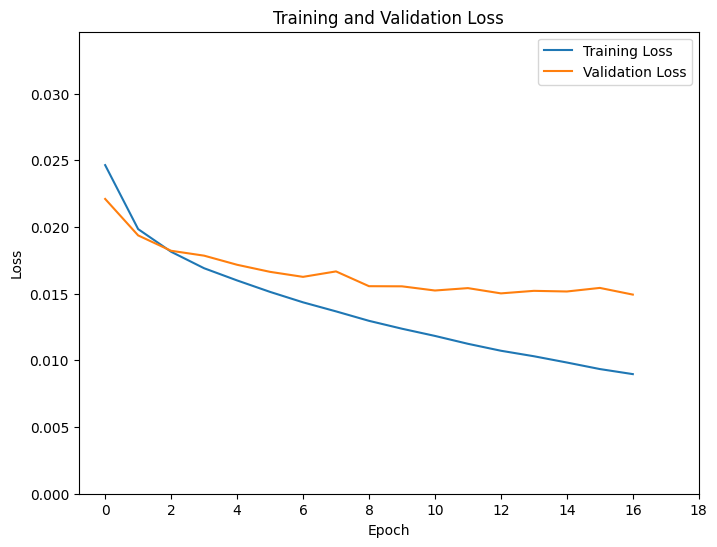

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses[:17], label='Training Loss')
plt.plot(val_losses[:17], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.01)
plt.yticks(np.arange(0, max(max(train_losses), max(val_losses)) + 0.01, 0.005))
plt.xticks(np.arange(0, 20,2))
plt.legend()
plt.show()

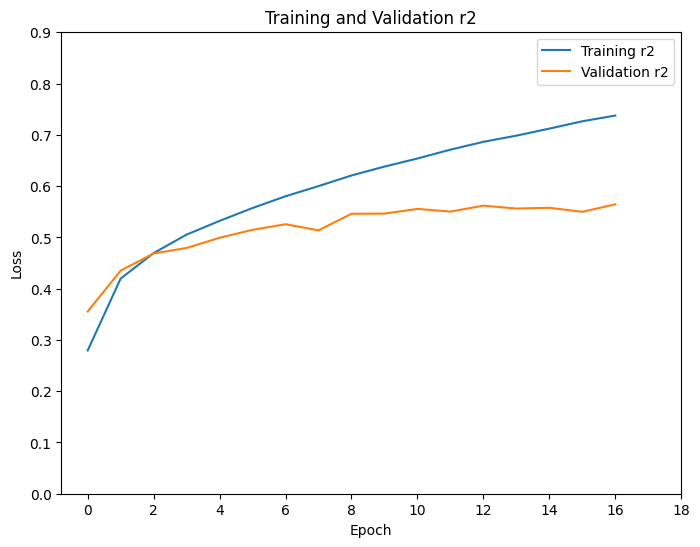

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(train_r2_list[:17], label='Training r2')
plt.plot(val_r2_list[:17], label='Validation r2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation r2')
plt.ylim(0, max(max(train_r2_list), max(val_r2_list)) + 0.1)
plt.yticks(np.arange(0, max(max(train_r2_list), max(val_r2_list)) + 0.1, 0.1))
plt.xticks(np.arange(0, 20, 2))
plt.legend()

In [25]:
model_dim = 256
num_heads = 8
num_layers = 2
dropout = 0.1
model = TransformerModel(vocab_size,model_dim, num_heads, num_layers,dropout=dropout).to(device)
criterion = nn.HuberLoss()

model.load_state_dict(torch.load('/kaggle/input/bestregnoesm/pytorch/default/1/bestmodel(0.57).pth',weights_only=True))

<All keys matched successfully>

Test Loss: 0.0148
Test R^2: 0.5706
Test MSE: 0.0295
Test MAE: 0.1322
Test RMSE: 0.3636


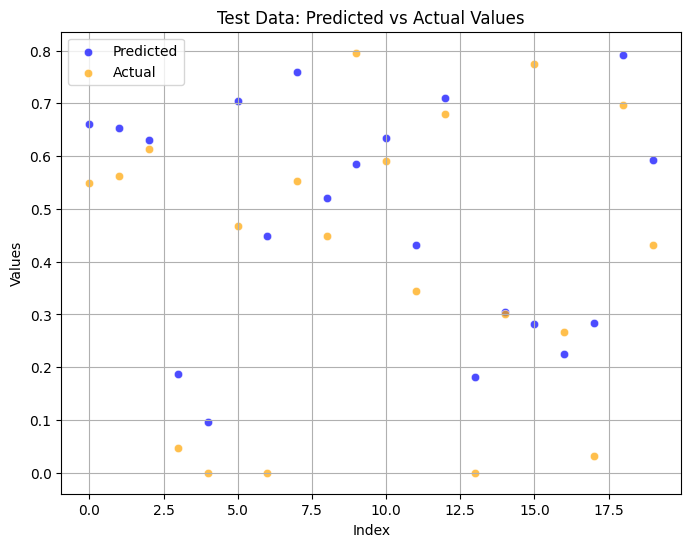

In [26]:

model.eval()
test_loss = 0
test_scores = []
test_predictions = []

with torch.no_grad():
    for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in test_loader:

        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
        pep_mask,mhc_mask = pep_mask.to(device),mhc_mask.to(device)
        outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask)


        test_scores.extend(scores.cpu().numpy())
        test_predictions.extend(outputs.cpu().numpy().flatten())


        loss = criterion(outputs.squeeze(), scores)
        test_loss += loss.item()


test_loss /= len(test_loader)


test_scores = np.array(test_scores)
test_predictions = np.array(test_predictions)
test_mse = mean_squared_error(test_scores, test_predictions)
test_mae = mean_absolute_error(test_scores, test_predictions)
test_rmse = np.sqrt(test_mse)


test_r2 = r2_score(test_scores, test_predictions)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


test_data = pd.DataFrame({
    'Index': np.arange(len(test_predictions[20:40])),
    'Predicted': test_predictions[20:40],
    'Actual': test_scores[20:40]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=test_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=test_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Test Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


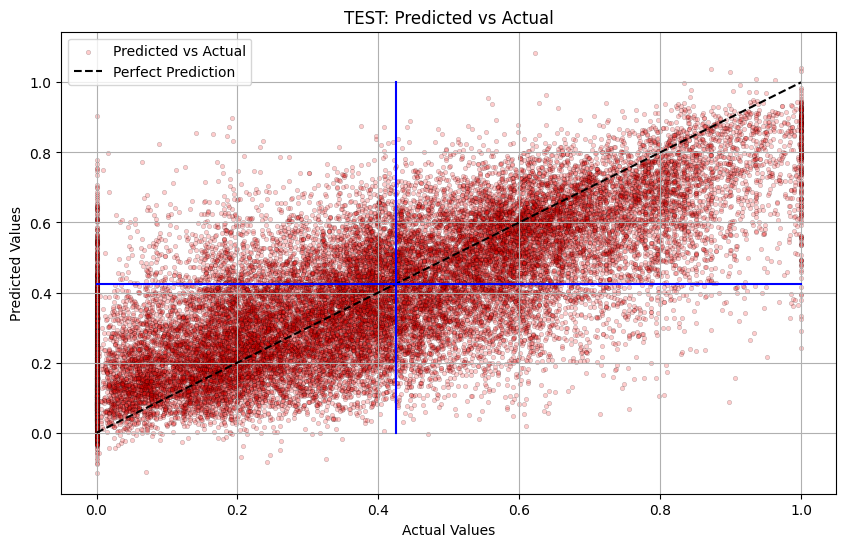

In [30]:
test_data = pd.DataFrame({
    'Predicted':test_predictions,
    'Actual': test_scores
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=10, alpha=0.2, edgecolor='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
threshold = 0.4256


Statistics for Test Scores:
        Test Scores
count  26857.000000
mean       0.380822
std        0.262244
min        0.000000
25%        0.168865
50%        0.369153
75%        0.578369
max        1.000000

Statistics for Test Predictions:
       Test Predictions
count      26857.000000
mean           0.385540
std            0.211527
min           -0.114170
25%            0.213954
50%            0.368576
75%            0.543576
max            1.084471

Statistics for Residuals:
          Residuals
count  26857.000000
mean      -0.004718
std        0.171786
min       -0.902576
25%       -0.108445
50%       -0.008950
75%        0.100442
max        0.808932


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


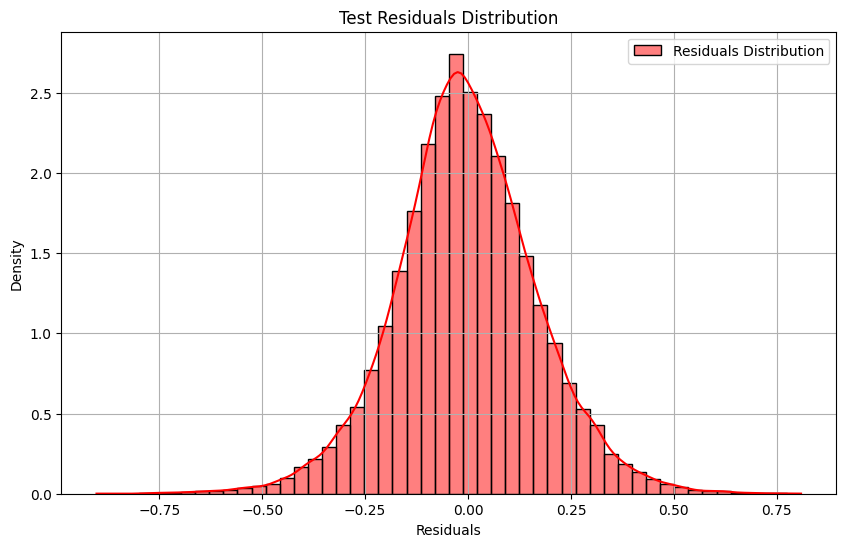

In [31]:
residuals = test_scores - test_predictions

# Create DataFrames
df_scores = pd.DataFrame(test_scores, columns=['Test Scores'])
df_preds = pd.DataFrame(test_predictions, columns=['Test Predictions'])
df_residuals = pd.DataFrame(residuals, columns=['Residuals'])

# Print statistics using .describe()
print("\nStatistics for Test Scores:")
print(df_scores.describe())

print("\nStatistics for Test Predictions:")
print(df_preds.describe())

print("\nStatistics for Residuals:")
print(df_residuals.describe())

# Plot residuals histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, stat='density', label='Residuals Distribution', color='red')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


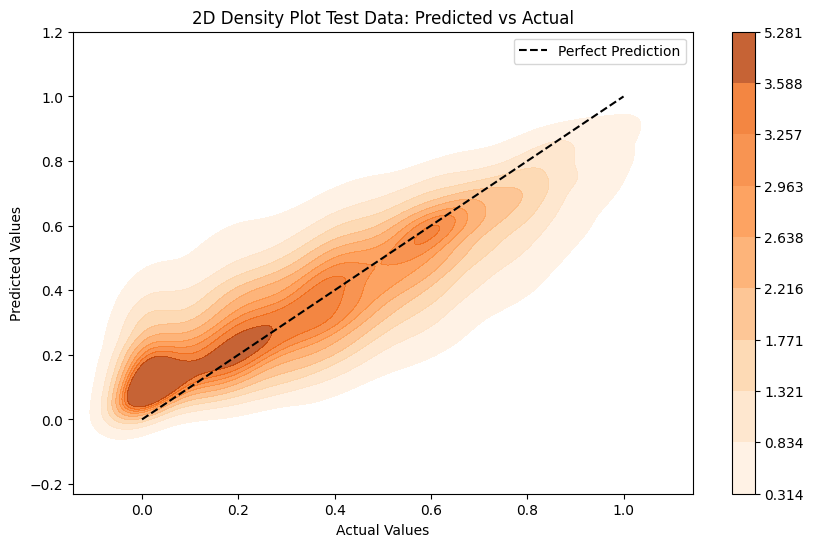

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


test_data = pd.DataFrame({
    'Predicted': test_predictions,
    'Actual': test_scores
})


plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=test_data['Actual'],
    y=test_data['Predicted'],
    cmap="Oranges",
    fill=True,
    levels=10,
    alpha=0.8,
    cbar=True
)


plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()

plt.show()


Kfold cross val


In [33]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold
import os



k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
batch_size = 128
epochs = 200
patience = 6
save_dir = '/kaggle/working/'

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [44]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
test_dataset = TensorDataset(X_test[: ,0],X_test[:,1],X_test[:,2],X_test[:,3], y_test)

In [45]:
batch_size=64

In [46]:
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f"Starting Fold {fold + 1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)


    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


    model = TransformerModel(vocab_size=vocab_size,model_dim=256, num_heads=8, num_layers=2, dropout=0.1).to(device)
    criterion = torch.nn.HuberLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

    best_val_loss = float("inf")
    patience_counter = 0
    #train loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train_preds, total_train_labels = [], []

        for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in train_loader:
            pep_ids, mhc_ids, pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_train_preds.append(outputs.detach().cpu())
            total_train_labels.append(scores.detach().cpu())

        train_loss /= len(train_loader)
        train_preds = torch.cat(total_train_preds).numpy().flatten()
        train_labels = torch.cat(total_train_labels).numpy().flatten()


        train_r2 = r2_score(train_labels, train_preds)
        train_mse = mean_squared_error(train_labels, train_preds)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(train_labels, train_preds)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, R²: {train_r2:.4f}, "
              f"MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

        #val loop
        model.eval()
        val_loss = 0
        total_val_preds, total_val_labels = [], []

        with torch.no_grad():
            for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in val_loader:
                pep_ids, mhc_ids, pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(outputs.cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)
        val_preds = torch.cat(total_val_preds).numpy().flatten()
        val_labels = torch.cat(total_val_labels).numpy().flatten()


        val_r2 = r2_score(val_labels, val_preds)
        val_mse = mean_squared_error(val_labels, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(val_labels, val_preds)

        print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, R²: {val_r2:.4f}, "
              f"MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth"))
            print(f"Saved best model for fold {fold + 1} with Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to no improvement in Val Loss")
                break

    print(f"Completed Fold {fold + 1}/{k_folds}")


Starting Fold 1/5
Epoch 1, Train Loss: 0.0252, R²: 0.2638, MSE: 0.0503, RMSE: 0.2244, MAE: 0.1812
Epoch 1, Val Loss: 0.0217, R²: 0.3673, MSE: 0.0434, RMSE: 0.2083, MAE: 0.1697
Saved best model for fold 1 with Val Loss: 0.0217
Epoch 2, Train Loss: 0.0197, R²: 0.4236, MSE: 0.0394, RMSE: 0.1985, MAE: 0.1582
Epoch 2, Val Loss: 0.0201, R²: 0.4141, MSE: 0.0402, RMSE: 0.2005, MAE: 0.1584
Saved best model for fold 1 with Val Loss: 0.0201
Epoch 3, Train Loss: 0.0182, R²: 0.4676, MSE: 0.0364, RMSE: 0.1908, MAE: 0.1511
Epoch 3, Val Loss: 0.0182, R²: 0.4689, MSE: 0.0364, RMSE: 0.1909, MAE: 0.1514
Saved best model for fold 1 with Val Loss: 0.0182
Epoch 4, Train Loss: 0.0170, R²: 0.5027, MSE: 0.0340, RMSE: 0.1844, MAE: 0.1450
Epoch 4, Val Loss: 0.0183, R²: 0.4649, MSE: 0.0367, RMSE: 0.1916, MAE: 0.1522
Epoch 5, Train Loss: 0.0161, R²: 0.5290, MSE: 0.0322, RMSE: 0.1795, MAE: 0.1405
Epoch 5, Val Loss: 0.0171, R²: 0.5000, MSE: 0.0343, RMSE: 0.1852, MAE: 0.1459
Saved best model for fold 1 with Val Loss:

In [47]:
models = []
for fold in range(1, 6):
    model = TransformerModel(vocab_size=vocab_size,model_dim=256, num_heads=8, num_layers=2, dropout=0.1).to(device)
    state_dict = torch.load(os.path.join(save_dir, f"best_model_fold_{fold}.pth"), weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()
    models.append(model)


In [48]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [49]:
total_preds = []
total_labels = []

for model in models:
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    preds = []
    labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids,pep_mask,mhc_mask, scores in test_loader:
            pep_ids, mhc_ids,pep_mask,mhc_mask, scores = pep_ids.to(device), mhc_ids.to(device),pep_mask.to(device),mhc_mask.to(device), scores.to(device)
            outputs = model(pep_ids, mhc_ids,pep_mask,mhc_mask)
            preds.append(outputs.cpu())
            labels.append(scores.cpu())

    total_preds.append(torch.cat(preds).numpy().flatten())
    total_labels.append(torch.cat(labels).numpy().flatten())


avg_preds = np.mean(total_preds, axis=0)
test_labels = total_labels[0]


test_r2 = r2_score(test_labels, avg_preds)
test_mse = mean_squared_error(test_labels, avg_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_labels, avg_preds)

print(f"Ensemble Test R²: {test_r2:.4f}")
print(f"Ensemble Test MSE: {test_mse:.4f}")
print(f"Ensemble Test RMSE: {test_rmse:.4f}")
print(f"Ensemble Test MAE: {test_mae:.4f}")


Ensemble Test R²: 0.6294
Ensemble Test MSE: 0.0255
Ensemble Test RMSE: 0.1597
Ensemble Test MAE: 0.1236


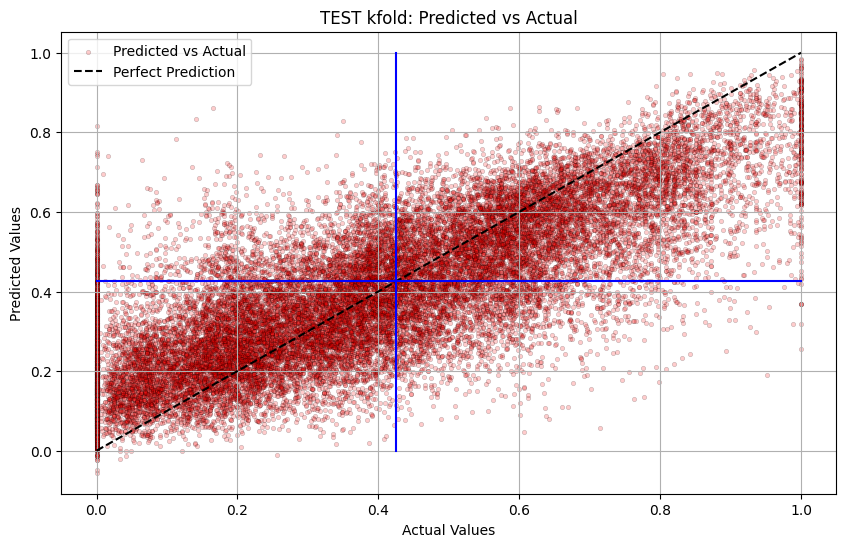

In [50]:
test_data = pd.DataFrame({
    'Predicted':avg_preds,
    'Actual': test_labels
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=10, alpha=0.2, edgecolor='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST kfold: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()


Statistics for Test Labels (True Values):
        Test Labels
count  26857.000000
mean       0.380822
std        0.262244
min        0.000000
25%        0.168865
50%        0.369153
75%        0.578369
max        1.000000

Statistics for Test Predictions (Predicted Values):
       Test Predictions
count      26857.000000
mean           0.390470
std            0.196128
min           -0.055353
25%            0.233538
50%            0.374080
75%            0.535869
max            0.983191

Statistics for K-Fold Residuals (Errors):
          Residuals
count  26857.000000
mean      -0.009648
std        0.159363
min       -0.816826
25%       -0.109866
50%       -0.014276
75%        0.088629
max        0.762114


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


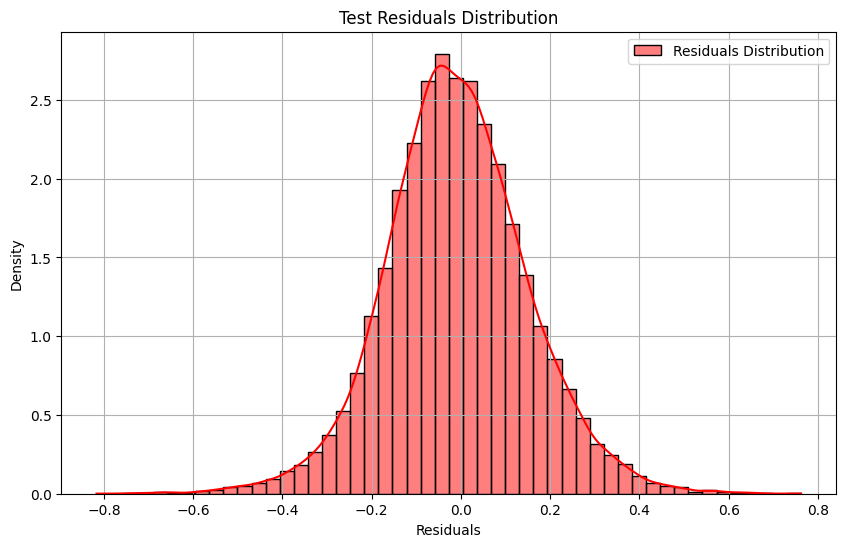

In [51]:
kfold_residuals = test_labels - avg_preds

# Create DataFrames
df_labels = pd.DataFrame(test_labels, columns=['Test Labels'])
df_preds = pd.DataFrame(avg_preds, columns=['Test Predictions'])
df_residuals = pd.DataFrame(kfold_residuals, columns=['Residuals'])

# Print statistics using .describe()
print("\nStatistics for Test Labels (True Values):")
print(df_labels.describe())

print("\nStatistics for Test Predictions (Predicted Values):")
print(df_preds.describe())

print("\nStatistics for K-Fold Residuals (Errors):")
print(df_residuals.describe())

# Plot residuals histogram
plt.figure(figsize=(10, 6))
sns.histplot(kfold_residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


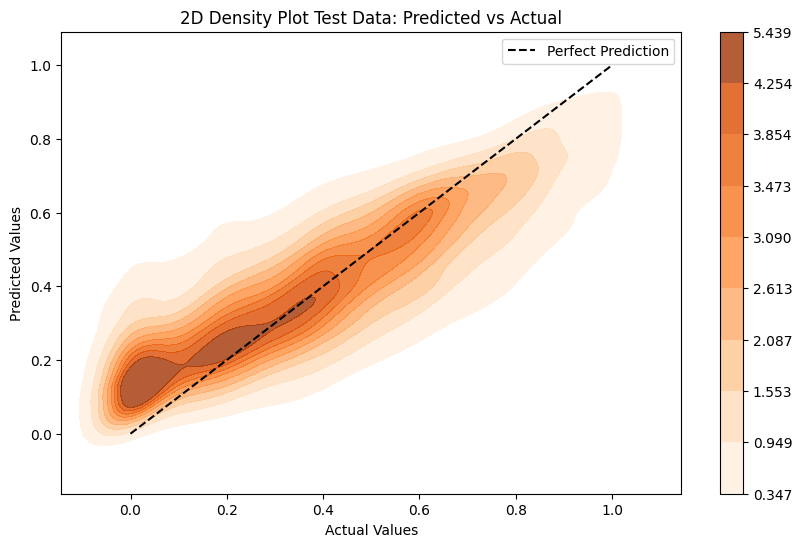

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


test_data = pd.DataFrame({
    'Predicted': avg_preds,
    'Actual': test_labels
})

plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=test_data['Actual'],
    y=test_data['Predicted'],
    cmap="Oranges",
    fill=True,
    levels=10,
    alpha=0.8,
    cbar=True
)

plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()
plt.show()
